In [659]:
from skimage import feature, data
import numpy as np
import matplotlib.pyplot as plt
from time import time
import cv2
import math
from scipy import signal

# Make matplotlib figures appear inline in the
# notebook rather than in a new window
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def display(img, title=None, size=5):
    # Show image
    plt.figure(figsize = (size, size))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()
    
def timing(f):
    # Timing decorator
    def out(*args, **kwargs):
        time1 = time()
        output = f(*args, **kwargs)
        time2 = time()
        
        print('{} function took {} seconds'.format(f.__name__, round(time2-time1, 5)))
        return output
    return out

In [660]:
iguana = cv2.imread('./iguana.png', 0)
board = cv2.imread('./board.png', 0)
build = cv2.imread('./build.png', 0)

# Laplacian of Gaussian (Doesn't Work)

Learned about this here: https://en.wikipedia.org/wiki/Corner_detection#Laplacian_of_Gaussian,_differences_of_Gaussians_and_determinant_of_the_Hessian_scale-space_interest_points

The idea behind the Laplace of Gaussian approach is to take the Laplacian (sum of second derivatives) of a Gaussian blur of an image at multiple "scales". In this case, a scale means a strength of the blur and a multiplier for the Laplacian output. The idea behind Laplace of Gaussian is that, at a feature/corner, the LoG will be high at many scales, as the Laplacian at such a point (which roughly corresponds to the difference of a point with the average of its surroundings) will be high. Thus, finding local maximums in the 3d space of $\text{Image} \times \text{Scales}$ will correspond to finding features.

In [661]:
def local_max(array):
    """
        Args:
            array: array of shape (3,3,3)
        Returns:
            result: float

        Returns the center of array if it is the maximum value else 0.
    """
    max_val = np.argmax(array)
    
    # Max value in center means its argument is 14 for a 3*3*3 box
    if max_val == 14:
        return array[1,1,1]
    
    return 0

In [696]:
def gauss_laplace(image, scale):
    """
        Args:
            array: grayscale image
            scale: positive float
        Returns:
            laplace: grayscale image

        Returns the Laplacian of a Gaussian blur with some scale.
    """
    blur = cv2.GaussianBlur(image, (0,0), scale)
    
    laplace = scale*cv2.Laplacian(blur, cv2.CV_16S, ksize=5)
    
    return laplace

@timing
def scale_LoG(image):
    """
        Args:
            image: grayscale image
        Returns:
            out: array of shape (image, 3)

        (Attempts to) perform scale Laplace of Gaussian feature detection.
        
        Performs a Laplace of Gaussian at various scales, and finds the 
        local maximums with respect to position and scale.
    """
    # Create a range of scales
    scales = np.linspace(1, 10, 10)
    
    shape = image.shape
    scale_images = np.zeros((*shape, len(scales)+1))
    
    # Create a tensor with all the different scaled LoGs
    for  i, scale in enumerate(scales):
        scale_images[:,:,i] = gauss_laplace(image, scale)
        
    out = np.zeros((*shape, len(scales)+1))
    
    # Find local max in 3*3*3 boxes
    for row in range(1, shape[0]-1):
        for column in range(1, shape[1]-1):
            for i in range(1, len(scales)+1):
                local_box = scale_images[row-1:row+1, column-1:column+1, i-1:i+1]
            
                out[row, column, i] = local_max(local_box)
            
    out = np.amax(out, axis=-1)
    
    return out

scale_LoG function took 5.17022 seconds


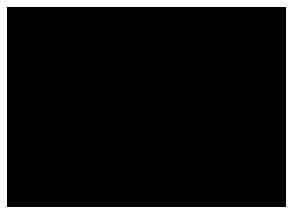

In [697]:
display(scale_LoG(iguana)>0)

Unfortunately, this doesn't work. I think I need to increase the number of scales, but that makes this run prohibitively slow. As such, I chose to move on to Harris corner detection.

# Harris Corner Detection

Harris corner detection learned from here:
https://medium.com/data-breach/introduction-to-harris-corner-detector-32a88850b3f6

The basic idea is to find points that are different from their surroundings; in particular, points that have a high sum-squared-difference compared to their neighbors (this is similar to the LoG method). By Taylor expanding the sum-squared-difference formula, you end up with a matrix $M$ involving sums of products of the gradients of the image in the $x$ and $y$ directions. The sum-squared-difference then becomes a quadratic form with matrix $M$. To find points that have high sum-squared-differences, we can therefore use the eigenvalues of $M$; in particular, we want both eigenvalues to be large and positive. Since $M$ is 2 by 2, its determinant and trace fully describe its eigenvalues. In particular, evaluating the expression $\det M-k(\text{trace } M)^2$, where $k\in[0.04,0.06]$, and seeing it is large indicates both eigenvalues are positive and large.

In [663]:
def thicken_corners(img, size):
    """
        Args:
            img: boolean array
            size: int
        Returns:
            result: boolean array of same size

        Thickens the true values of input boolean array according to size variable.

        This is done by adding various shifts of img to itself.
    """
    vertical = img.copy()
     
    # Get left-right thickness by adding horizontal shifts
    for i in range(1, size):
        vertical += np.pad(img[i:,:], ((0,i), (0,0)))
        vertical += np.pad(img[:-i,:], ((i,0), (0,0)))
    
    result = vertical.copy()
    
    # Get all other directions by adding up-down vertical shifts
    # Which include the added left-right shifts
    for i in range(1, size):
        result += np.pad(vertical[:,i:], ((0,0), (0,i)))
        result += np.pad(vertical[:,:-i], ((0,0), (i,0)))
    
    return result > 0

In [664]:
@timing
def Harris(img, quantile=0.95, k=0.05, dotsize=0, sigma=0):
    """
        Args:
            img: grayscale image
            k: float
            low_thresh: float
            dotsize: int
        Returns:
            out1: grayscale image
            out2: RGB image

        Performs Harris corner detection on img with parameters k and low_thresh.
        
        out1 returns all of the found corners. 
        out2 returns the original image with red dots placed at the corners, with
        dotsize determining the size of these dots.
    """
    # Set up image and output
    shape = img.shape
    blur = cv2.GaussianBlur(img, (5,5), sigma)
    out1 = np.zeros(shape)

    # Define function that sums over an image in 3*3 windows
    sum_filter = np.ones((3,3))
    window_sum = lambda x: signal.correlate2d(x, sum_filter, mode='same').astype(np.uint32)
    
    # Get gradients
    Ix = cv2.Sobel(blur, cv2.CV_16S, 1, 0, ksize=3)
    Iy = cv2.Sobel(blur, cv2.CV_16S, 0, 1, ksize=3)
    
    # Get relevant summed gradient products
    summed_Ix_2 = window_sum(Ix**2)
    summed_Iy_2 = window_sum(Iy**2)
    summed_Ixy = window_sum(Ix * Iy)
    
    # Calculate Harris Corner detection parameter
    dets = summed_Ix_2*summed_Iy_2 - (summed_Ixy)**2
    traces = summed_Ix_2 + summed_Iy_2
    out1 = dets - k*(traces**2)
    
    # Low thresholdling by quantile
    low_thresh = np.quantile(out1, quantile)
    out1 = np.where(out1 < low_thresh, 0, out1)
    
    # Set up second output
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    out2 = np.copy(img)
    
    # Set dotsize
    if dotsize == 0:
        dotsize = min(shape)//200 
      
    # Get thickened corner mask to mask second output
    mask = thicken_corners(out1, dotsize)
    out2[mask] = [255,0,0]
            
    return out1, out2

Harris function took 0.02392 seconds


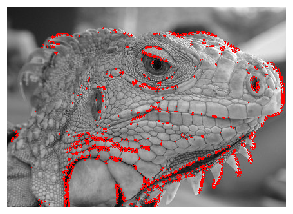

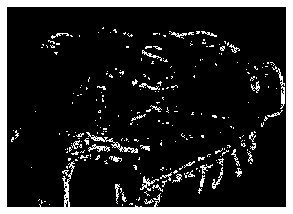

In [665]:
corners, image = Harris(iguana)

display(image)
display(corners>0)

Harris function took 0.05103 seconds


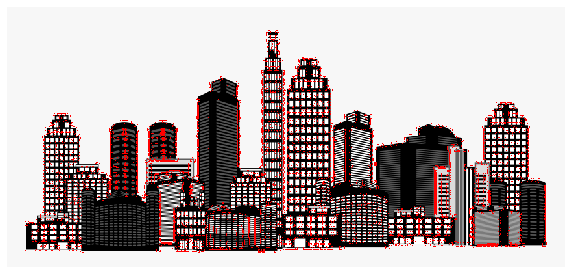

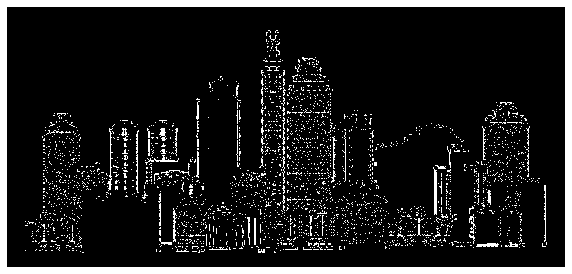

In [666]:
corners, image = Harris(build, dotsize=1)

display(image, size=10)
display(corners>0, size=10)

Harris function took 0.09627 seconds


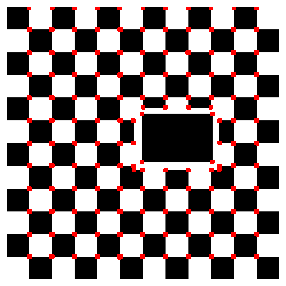

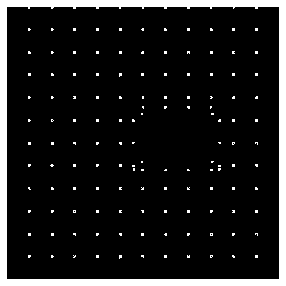

In [667]:
corners, image = Harris(board)

display(image)
display(corners>0)